# Very naive learning on the vector of surrounding bases with standardish machine learning algorithms from scikit sklearn

---

### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!


Only CpG islands used now

### Analysis


### Conlcusions


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline

import time

from sklearn import tree
from sklearn import svm
from sklearn import ensemble

import sys
sys.path.append('../my_modules')
from loading_utils import read_my_data

import os,subprocess
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
train_id,train_x,train_y = read_my_data(fname='../prepare_data/big_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(fname='../prepare_data/big_test_feat_vect.csv')

Loading data... 
Loading data... 


### Load annotation

In [3]:
annot=pd.read_csv('../explore_data/relevant_annotations.csv',sep='\t',header=None)
annot.columns=['id','Regulatory_Feature_Group','Relation_to_UCSC_CpG_Island',
    'Strand','Infinium_Design_Type','Random_Loci','Methyl27_Loci']
annot.fillna(0,inplace=True)
train_merged=pd.DataFrame(train_id,columns=['id']).merge(annot,on=['id'])
test_merged=pd.DataFrame(test_id,columns=['id']).merge(annot,on=['id'])

### Define indices

In [4]:
cg_exl_idx=np.array([x[499]==2 and x[500]==3 for x in train_x])
annot_idx=np.array(np.zeros(len(train_x)),dtype=bool)
annot_idx[train_merged[train_merged.Relation_to_UCSC_CpG_Island=='Island'].index]=True
train_idx=cg_exl_idx & annot_idx
train_idx_0=cg_exl_idx & annot_idx & (train_y ==0)
train_idx_1=cg_exl_idx & annot_idx & (train_y ==1)


cg_exl_idx=np.array([x[499]==2 and x[500]==3 for x in test_x])
annot_idx=np.array(np.zeros(len(test_x)),dtype=bool)
annot_idx[test_merged[test_merged.Relation_to_UCSC_CpG_Island=='Island'].index]=True
test_idx=cg_exl_idx & annot_idx
test_idx_0=cg_exl_idx & annot_idx & (test_y==0)
test_idx_1=cg_exl_idx & annot_idx & (test_y==1)

In [8]:
def test_sklearn_model(model,train_x,train_y,test_x,test_y):
    start=time.time()
    model=model.fit(train_x,train_y)
    
    train_pred=model.predict(train_x)
    test_pred=model.predict(test_x)
    
    train_pred_pr=model.predict_proba(train_x)
    test_pred_pr=model.predict_proba(test_x)
    
    print 'train score:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test score:',list((test_pred==test_y)).count(True)/float(len(test_y))
    print 'It took:',time.time()-start
    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [28]:
from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

---

# Random Forest


### Balance it

In [6]:
bal_train_x=np.concatenate([train_x[train_idx_0][:np.sum(train_idx_1)],train_x[train_idx_1]])
bal_train_y=np.concatenate([train_y[train_idx_0][:np.sum(train_idx_1)],train_y[train_idx_1]])

bal_test_x=np.concatenate([test_x[test_idx_0][:np.sum(test_idx_1)],test_x[test_idx_1]])
bal_test_y=np.concatenate([test_y[test_idx_0][:np.sum(test_idx_1)],test_y[test_idx_1]])

print np.mean(bal_train_y)
print np.mean(bal_test_y)

0.5
0.5


In [7]:
bal_train_x[bal_train_x==4]=5
bal_train_x[bal_train_x==2]=4
bal_train_x[bal_train_x==5]=2

bal_test_x[bal_test_x==4]=5
bal_test_x[bal_test_x==2]=4
bal_test_x[bal_test_x==5]=2

In [10]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_split=5,n_jobs=6)
train_pred,test_pred,train_pred_pr,test_pred_pr=test_sklearn_model(
    rf,bal_train_x,bal_train_y,bal_test_x,bal_test_y)

print '\nprediction balance:'
print np.mean(train_pred)
print np.mean(test_pred)

train score: 1.0
test score: 0.629702970297
It took: 62.6087169647

prediction balance:
0.5
0.505940594059


auc: 0.69233996667


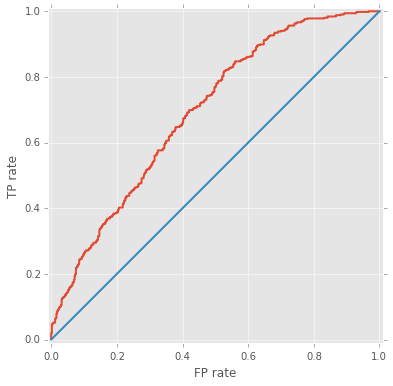

In [29]:
plot_roc(bal_test_y,test_pred_pr[:,1])

---
## Feature importance

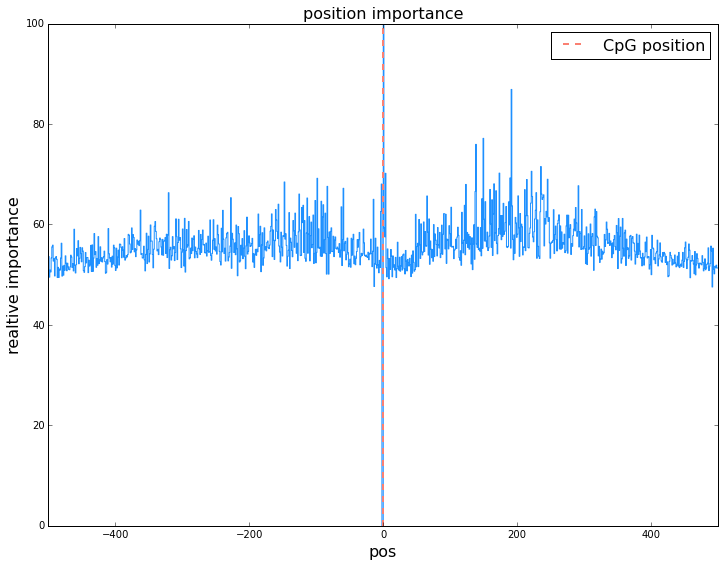

In [13]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_split=5,n_jobs=12)
model=rf.fit(bal_train_x,bal_train_y)
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

fig,ax=plt.subplots()
fig.set_size_inches(12,9)
ax.step(np.arange(len(feature_importance))-500, feature_importance,lw=1,c='dodgerblue')
ax.axvline(0,lw=2,linestyle='dashed',c='salmon',label='CpG position')
ax.set_ylabel('realtive importance',fontsize=16)
ax.set_xlabel('pos',fontsize=16)
ax.set_xlim(-500,500)
ax.legend(fontsize=16)
dump=ax.set_title('position importance',fontsize=16)